New plan: 
1. EDA of real data
2. preprocessing
3. train, val, test with only real data
4. recall, precision, micro macro avg etc.
5. hyper param tuning?
6. identify same syntetic and real data 
7. train,val, test with real and syntetic data
8. compare results
9. conclusion

---

# Multi-Class Prediction of Obesity Risk

Intro here

# Setup

In [1]:
!pip install ydata-profiling
!pip install lazypredict
!pip install catboost
!pip install ipywidgets
!pip install lazypredict==0.2.16
!pip install scikit-learn==1.4.2


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

import lazypredict
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [3]:
real_data = pd.read_csv('/work/real-data.csv')

# Understanding the Data

## Data Description

TODO: descr as table

There are some signs that one has risk to develop obesity. We want to understand by what this risk is influenced. Further we will predict the obesity risk based on the given properties 

The risk class are:
* Underweight Less than 18.5
* Normal 18.5 to 24.9
* Overweight 25.0 to 29.9
* Obesity I 30.0 to 34.9
* Obesity II 35.0 to 39.9
* Obesity III Higher than 40

Features:

The attributes related with eating habits are: 
* Frequent consumption of high caloric food (FAVC)
* Frequency of consumption of vegetables (FCVC)
* Number of main meals (NCP)
* Consumption of food between meals (CAEC)
* Consumption of water daily (CH20)
* Consumption of alcohol (CALC)

The attributes related with the physical condition are: 
* Calories consumption monitoring (SCC)
* Physical activity frequency (FAF)
* Time using technology devices (TUE)
* Transportation used (MTRANS)

## EDA

TODO: add more plots

In [4]:
real_data

Gender        Age    Height      Weight family_history_with_overweight  \
0     Female  21.000000  1.620000   64.000000                            yes   
1     Female  21.000000  1.520000   56.000000                            yes   
2       Male  23.000000  1.800000   77.000000                            yes   
3       Male  27.000000  1.800000   87.000000                             no   
4       Male  22.000000  1.780000   89.800000                             no   
...      ...        ...       ...         ...                            ...   
2106  Female  20.976842  1.710730  131.408528                            yes   
2107  Female  21.982942  1.748584  133.742943                            yes   
2108  Female  22.524036  1.752206  133.689352                            yes   
2109  Female  24.361936  1.739450  133.346641                            yes   
2110  Female  23.664709  1.738836  133.472641                            yes   

     FAVC  FCVC  NCP       CAEC SMOKE      CH2O  SCC       FAF       TUE  \
0      no   2.0  3.0  Sometimes    no  2.000000   no  0.000000  1.000000   
1      no   3.0  3.0  Sometimes   yes  3.000000  yes  3.000000  0.000000   
2      no   2.0  3.0  Sometimes    no  2.000000   no  2.000000  1.000000   
3      no   3.0  3.0  Sometimes    no  2.000000   no  2.000000  0.000000   
4      no   2.0  1.0  Sometimes    no  2.000000   no  0.000000  0.000000   
...   ...   ...  ...        ...   ...       ...  ...       ...       ...   
2106  yes   3.0  3.0  Sometimes    no  1.728139   no  1.676269  0.906247   
2107  yes   3.0  3.0  Sometimes    no  2.005130   no  1.341390  0.599270   
2108  yes   3.0  3.0  Sometimes    no  2.054193   no  1.414209  0.646288   
2109  yes   3.0  3.0  Sometimes    no  2.852339   no  1.139107  0.586035   
2110  yes   3.0  3.0  Sometimes    no  2.863513   no  1.026452  0.714137   

            CALC                 MTRANS           NObeyesdad  
0             no  Public_Transportation        Normal_Weight  
1      Sometimes  Public_Transportation        Normal_Weight  
2     Frequently  Public_Transportation        Normal_Weight  
3     Frequently                Walking   Overweight_Level_I  
4      Sometimes  Public_Transportation  Overweight_Level_II  
...          ...                    ...                  ...  
2106   Sometimes  Public_Transportation     Obesity_Type_III  
2107   Sometimes  Public_Transportation     Obesity_Type_III  
2108   Sometimes  Public_Transportation     Obesity_Type_III  
2109   Sometimes  Public_Transportation     Obesity_Type_III  
2110   Sometimes  Public_Transportation     Obesity_Type_III  

[2111 rows x 17 columns]

In [5]:
real_data.describe()

Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866  
std       0.612953     0.850592     0.608927  
min       1.000000     0.000000     0.000000  
25%       1.584812     0.124505     0.000000  
50%       2.000000     1.000000     0.625350  
75%       2.477420     1.666678     1.000000  
max       3.000000     3.000000     2.000000

In [6]:
real_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [7]:
# Kopiere das Original, um es nicht zu überschreiben
real_data_new = real_data.copy()

# ========== 1. Add BMI ==========
# BMI = Body Mass Index = Gewicht in kg / (Größe in m)^2
real_data_new['BMI'] = real_data_new['Weight'] / (real_data_new['Height'] ** 2)

"""# ========== 2. Add BMR ==========
# BMR = Grundumsatz in kcal/Tag (Harris-Benedict-Formel)
def calculate_bmr(row):
    height_cm = row['Height'] * 100
    if row['Gender'] == 'Male':
        return 66.47 + (13.75 * row['Weight']) + (5.003 * height_cm) - (6.755 * row['Age'])
    else:
        return 655.1 + (9.563 * row['Weight']) + (1.850 * height_cm) - (4.676 * row['Age'])

real_data_new['BMR'] = real_data_new.apply(calculate_bmr, axis=1)"""

# ========== 3. Add IBW ==========
# IBW = Idealgewicht nach der Devine-Formel (je nach Geschlecht)
def calculate_ibw(row):
    height_cm = row['Height'] * 100
    if row['Gender'] == 'Male':
        return 50 + 2.3 * ((height_cm - 152.4) / 2.54)
    else:
        return 45.5 + 2.3 * ((height_cm - 152.4) / 2.54)

real_data_new['IBW'] = real_data_new.apply(calculate_ibw, axis=1)

"""# ========== 4. Add TDEE ==========
# TDEE = Gesamtumsatz = BMR * Aktivitätsfaktor
def calculate_tdee(row):
    bmr = calculate_bmr(row)
    activity_levels = {
        'Sedentary': 1.2,
        'Lightly_active': 1.375,
        'Moderately_active': 1.55,
        'Very_active': 1.725,
        'Extra_active': 1.9
    }
    return bmr * activity_levels.get(row['Activity_Level'], 1.2)  # fallback auf Sedentary

real_data_new['TDEE'] = real_data_new.apply(calculate_tdee, axis=1)"""


"# ========== 4. Add TDEE ==========\n# TDEE = Gesamtumsatz = BMR * Aktivitätsfaktor\ndef calculate_tdee(row):\n    bmr = calculate_bmr(row)\n    activity_levels = {\n        'Sedentary': 1.2,\n        'Lightly_active': 1.375,\n        'Moderately_active': 1.55,\n        'Very_active': 1.725,\n        'Extra_active': 1.9\n    }\n    return bmr * activity_levels.get(row['Activity_Level'], 1.2)  # fallback auf Sedentary\n\nreal_data_new['TDEE'] = real_data_new.apply(calculate_tdee, axis=1)"

In [8]:
profile = ProfileReport(real_data_new, title="Profiling Report - Real data")

In [9]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 19/19 [00:00<00:00, 74.48it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# Export to HTML
profile.to_file("real_data_new_profile_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# Remove duplicate rows from real_data_new
real_data_new = real_data_new.drop_duplicates().reset_index(drop=True)

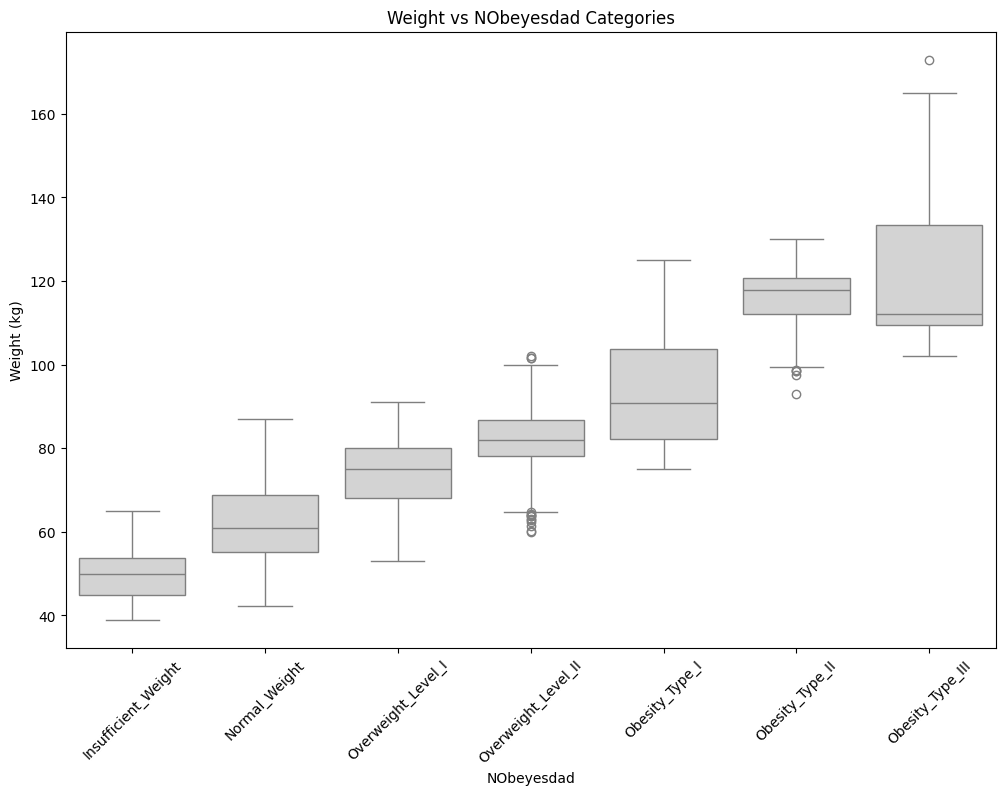

In [12]:
%matplotlib inline

# Manually specify the desired order of the NObeyesdad categories
ordered_categories = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

# Plotting with manually specified category order
plt.figure(figsize=(12, 8))
sns.boxplot(x='NObeyesdad', y='Weight', data=real_data_new, order=ordered_categories, color='lightgrey')
plt.title('Weight vs NObeyesdad Categories')
plt.ylabel('Weight (kg)')
plt.xticks(rotation=45)
plt.show()

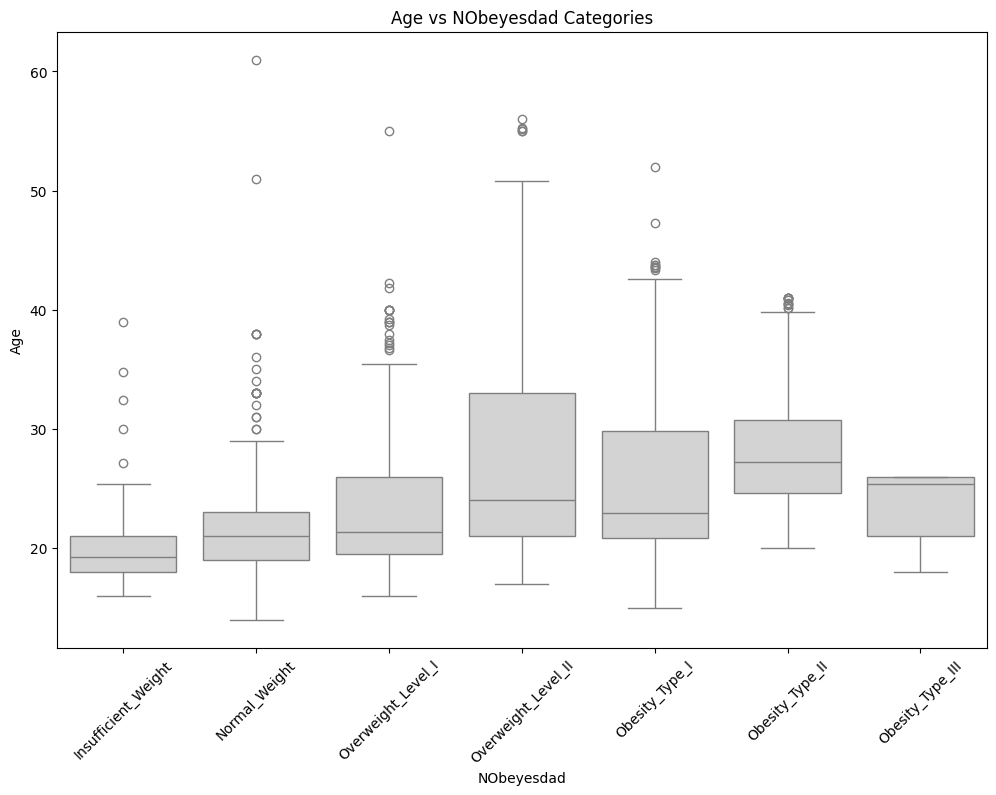

In [13]:
# Plotting with manually specified category order and setting the color to light grey
plt.figure(figsize=(12, 8))
sns.boxplot(x='NObeyesdad', y='Age', data=real_data_new, order=ordered_categories, color='lightgrey')
plt.title('Age vs NObeyesdad Categories')
plt.ylabel('Age')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability
plt.show()

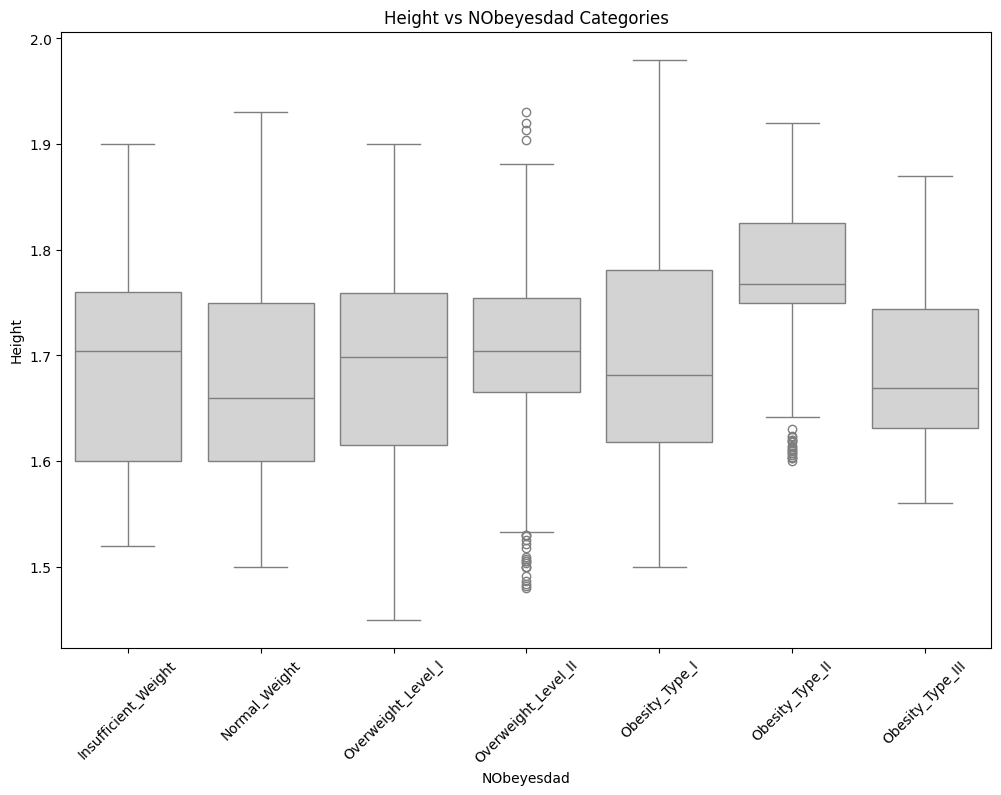

In [14]:
# Plotting with manually specified category order
plt.figure(figsize=(12, 8))
sns.boxplot(x='NObeyesdad', y='Height', data=real_data_new, order=ordered_categories, color='lightgrey')
plt.title('Height vs NObeyesdad Categories')
plt.ylabel('Height')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x800 with 0 Axes>

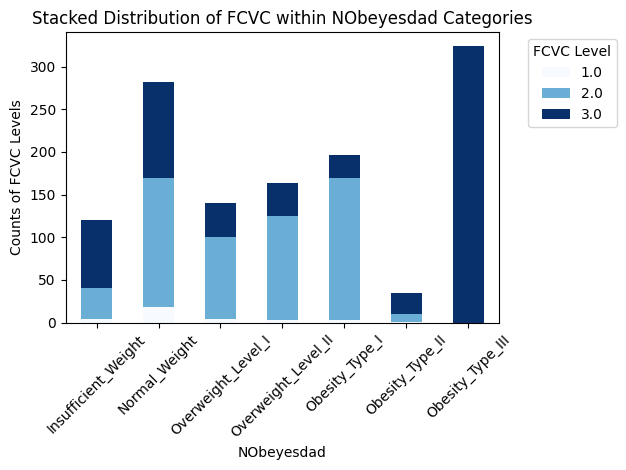

In [15]:
# Filter the DataFrame to include only rows where FCVC has values 1, 2, or 3
filtered_data = real_data_new[real_data_new['FCVC'].isin([1, 2, 3])]

# Create a DataFrame with counts of 'FCVC' for each 'NObeyesdad' category
counts_df_fcvc_stacked = filtered_data.groupby(['NObeyesdad', 'FCVC']).size().unstack(fill_value=0)

# Reorder the DataFrame according to the manually specified order of the NObeyesdad categories
counts_df_fcvc_stacked = counts_df_fcvc_stacked.reindex(ordered_categories)

# Plotting a stacked bar plot for FCVC
plt.figure(figsize=(12, 8))
counts_df_fcvc_stacked.plot(kind='bar', stacked=True, colormap='Blues')
plt.title('Stacked Distribution of FCVC within NObeyesdad Categories')
plt.ylabel('Counts of FCVC Levels')
plt.xticks(rotation=45) 
plt.legend(title='FCVC Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

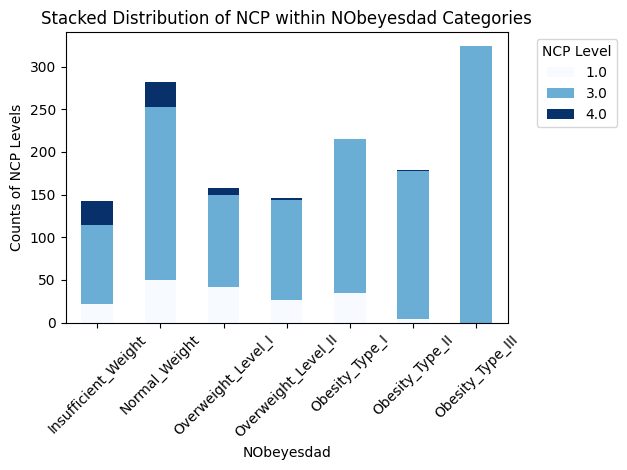

In [16]:
# Filter the DataFrame to include only rows where NCP has values 1, 2, 3 or 4
filtered_data_ncp = real_data_new[real_data_new['NCP'].isin([1, 2, 3, 4])]

# Create a DataFrame with counts of 'FCVC' for each 'NObeyesdad' category
counts_df_ncp_stacked = filtered_data_ncp.groupby(['NObeyesdad', 'NCP']).size().unstack(fill_value=0)

# Reorder the DataFrame according to the manually specified order of the NObeyesdad categories
counts_df_ncp_stacked = counts_df_ncp_stacked.reindex(ordered_categories)

# Plotting a stacked bar plot for NCP
plt.figure(figsize=(12, 8))
counts_df_ncp_stacked.plot(kind='bar', stacked=True, colormap='Blues')
plt.title('Stacked Distribution of NCP within NObeyesdad Categories')
plt.ylabel('Counts of NCP Levels')
plt.xticks(rotation=45)
plt.legend(title='NCP Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

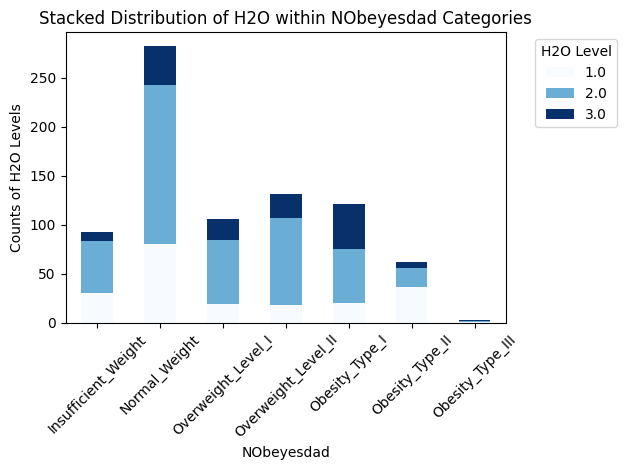

In [17]:
# Filter the DataFrame to include only rows where CH2O has values 1, 2, or 3
filtered_data_ch2O = real_data_new[real_data_new['CH2O'].isin([1, 2, 3])]

# Create a DataFrame with counts of 'CH2O' for each 'NObeyesdad' category
counts_df_ch2O_stacked = filtered_data_ch2O.groupby(['NObeyesdad', 'CH2O']).size().unstack(fill_value=0)

# Reorder the DataFrame according to the manually specified order of the NObeyesdad categories
counts_df_ch2O_stacked = counts_df_ch2O_stacked.reindex(ordered_categories)

# Plotting a stacked bar plot for CH2O
plt.figure(figsize=(12, 8))
counts_df_ch2O_stacked.plot(kind='bar', stacked=True, colormap='Blues')
plt.title('Stacked Distribution of H2O within NObeyesdad Categories')
plt.ylabel('Counts of H2O Levels')
plt.xticks(rotation=45)
plt.legend(title='H2O Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

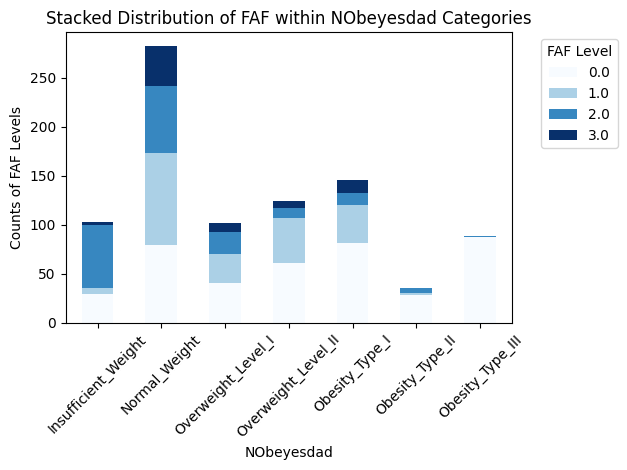

In [18]:
# Filter the DataFrame to include only rows where FAF has values 0, 1, 2, or 3
filtered_data_faf = real_data_new[real_data_new['FAF'].isin([0, 1, 2, 3])]

# Create a DataFrame with counts of 'FAF' for each 'NObeyesdad' category
counts_df_faf_stacked = filtered_data_faf.groupby(['NObeyesdad', 'FAF']).size().unstack(fill_value=0)

# Reorder the DataFrame according to the manually specified order of the NObeyesdad categories
counts_df_faf_stacked = counts_df_faf_stacked.reindex(ordered_categories)

# Plotting a stacked bar plot for FAF
plt.figure(figsize=(12, 8))
counts_df_faf_stacked.plot(kind='bar', stacked=True, colormap='Blues')
plt.title('Stacked Distribution of FAF within NObeyesdad Categories')
plt.ylabel('Counts of FAF Levels')
plt.xticks(rotation=45)
plt.legend(title='FAF Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Oberservations:**
* The weight definitely influences the risk for obesity, which is expected 
* It seems that age does not influence the risk for obesity, as the distribution in each target class is almost equal
* It seems that height does not influence the risk for obesity, as the distribution in each target class is almost equal but people with Obesity Type II have a higher mean height than all
* People with Obesity Type III with less than three meals are rare 
* The phyisical activity frequency of people with Obesity Type II and III quite low compared to other

# Preprocessing

* no missing values DONE
* remove duplicates DONE 
* handle outlier DONE with standardscaler
* normalize age, weight and age DONE
* transform boolean to binary DONE
* transform categorical variables DONE

In [19]:
# Separate features and target
X = real_data_new.drop(columns='NObeyesdad')  # Replace 'target' with your actual column name
y = real_data_new['NObeyesdad']               # Replace as needed

# Step 1: Split off the test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

# Step 2: Split remaining into train (60%) and val (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)  
# 0.25 of 80% = 20% total

# Wrap them into DataFrames for easier handling later
train_df = pd.concat([X_train, y_train], axis=1)
val_df   = pd.concat([X_val, y_val], axis=1)
test_df  = pd.concat([X_test, y_test], axis=1)

In [20]:
# Step 2: Custom transformer to convert 'yes'/'no' to 1/0
class BooleanToBinaryTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.replace({'yes': 1, 'no': 0})

# Step 3: Define feature groups
numerical_features = ['Age', 'Height', 'Weight', 'BMI', "IBW"]
boolean_features = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
categorical_features = ['CAEC', 'CALC', 'MTRANS', 'Gender']

# Step 4: Define transformers
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

boolean_transformer = Pipeline([
    ('boolean_to_binary', BooleanToBinaryTransformer())
])

categorical_transformer = Pipeline([
    ('onehotencoder',OneHotEncoder())#handle_unknown='ignore'), sparse=False)
])

# Step 5: Combine all transformers into one preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('bool', boolean_transformer, boolean_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Leave the rest of the columns as they are
)

# Define base models
base_models = [
    ('ada', AdaBoostClassifier(n_estimators=1000, random_state=0)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=0)),
    ('svc', SVC(kernel='linear', probability=True, random_state=0))
]

# Define the meta-model
meta_model = RandomForestClassifier(n_estimators=1000, random_state=0)

# Create the stacking classifier
stacking_classifier = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=10
)

# Create the full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', stacking_classifier)
])

In [21]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'BMI', 'IBW']),
                                                 ('bool',
                                                  Pipeline(steps=[('boolean_to_binary',
                                                                   BooleanToBinaryTransformer())]),
                                                  ['family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencod...
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('svc',
                                                 SVC(kernel='linear',
                                                     probability=True,
                                                     random_state=0))],
                                    final_estimator=RandomForestClassifier(n_estimators=1000,
                                                                           random_state=0)))])

# Modeling

## Baseline

In [22]:
# Fix the OneHotEncoder initialization in the preprocessing pipeline
# Define transformers
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

boolean_transformer = Pipeline([
    ('boolean_to_binary', BooleanToBinaryTransformer())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))  # Fixed initialization
])

# Combine all transformers into one preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('bool', boolean_transformer, boolean_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Now apply the preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [37]:
# Now run the LazyClassifier code
from lazypredict.Supervised import LazyClassifier

lazy_clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_clf.fit(X_train_transformed, X_test_transformed, y_train, y_test)

# Show the results
print(models)

  0%|          | 0/29 [00:00<?, ?it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.5789473684210527, 'Balanced Accuracy': 0.5648838845883181, 'ROC AUC': None, 'F1 Score': 0.44209261773561237, 'Time taken': 0.186265230178833}
{'Model': 'BaggingClassifier', 'Accuracy': 0.9760765550239234, 'Balanced Accuracy': 0.9745530445766722, 'ROC AUC': None, 'F1 Score': 0.9759420309016448, 'Time taken': 0.05526304244995117}
{'Model': 'BernoulliNB', 'Accuracy': 0.6866028708133971, 'Balanced Accuracy': 0.6757166986272606, 'ROC AUC': None, 'F1 Score': 0.68612934936306, 'Time taken': 0.015176057815551758}
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.784688995215311, 'Balanced Accuracy': 0.7810826915781887, 'ROC AUC': None, 'F1 Score': 0.7738134429723049, 'Time taken': 0.1946425437927246}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.9784688995215312, 'Balanced Accuracy': 0.9778482601142701, 'ROC AUC': None, 'F1 Score': 0.9784190430104133, 'Time taken': 0.017288684844970703}
{'Model': 'DummyClassifier', 'Accuracy': 0.167464114832535

## Ensemble

In [ ]:
pipeline.fit(X_train, y_train)

In [1]:
# Make predictions on the training data
train_predictions = pipeline.predict(X_train)

# Generate a classification report for the training data
classification_report_train = classification_report(y_train, train_predictions)

print("Classification Report (Training Data):\n", classification_report_train)

confusion_matrix_train = confusion_matrix(y_train, train_predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Training Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

NameError: name 'pipeline' is not defined

# Evaluation

In [1]:
# Make predictions on the training data
val_predictions = pipeline.predict(X_val)

# Assuming you have ground truth labels for the training data called 'y_train'
classification_report_val = classification_report(y_val, val_predictions)

print("Classification Report (Validation Data):\n", classification_report_val)

confusion_matrix_val = confusion_matrix(y_val, val_predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_val, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Validation Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

NameError: name 'pipeline' is not defined

# Hyperparameter-Tuning

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=0)

grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search.fit(X_train_transformed, y_train)

best_lgbm = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

In [ ]:
# TODO: add bayesian hyperparameter tuning

"""
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=3, 
    verbose=1,  
    n_jobs=-1
)

# Fit RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
"""

In [ ]:
"""
# Make predictions on the training data
fine_tuning_predictions = random_search.predict(X_val)

# Assuming you have ground truth labels for the training data called 'y_train'
classification_report_ft = classification_report(y_val, fine_tuning_predictions)

print("Classification Report (Validation Data):\n", classification_report_val)

confusion_matrix_ft = confusion_matrix(y_val, fine_tuning_predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_ft, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Validation Data)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
"""

# Submission to Kaggle competition

In [ ]:
test_ids = test['id']

# Drop the 'id' and 'NObeyesdad' columns from the DataFrame to create X_train
X_test = test.drop(['id'], axis=1)

In [ ]:
# Make predictions on the training data
test_predictions = pipeline.predict(X_test)

In [ ]:
# Create a DataFrame for the submission
submission_df = pd.DataFrame({'id': test_ids, 'Prediction': test_predictions})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

# From here analysis with synthetic data

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a441f35e-4b4c-4c50-b56a-1aea6b800ed8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>